In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1, ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import numpy as np
import os

# ---------------- Enhanced Data Augmentation ---------------- #
def enhanced_data_augmentation():
    return ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,  # Increased
        width_shift_range=0.3,  # Increased
        height_shift_range=0.3,  # Increased
        brightness_range=[0.8, 1.2],  # Contrast adjustment
        shear_range=0.3,
        zoom_range=0.3,  # More zoom variation
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

# ---------------- Load Client Data with Class Weights ---------------- #
def load_client_data(client_id, dataset_path):
    client_dir = os.path.join(dataset_path, f'client_{client_id}')
    if not os.path.exists(client_dir):
        raise FileNotFoundError(f"Client dataset not found: {client_dir}")

    train_datagen = enhanced_data_augmentation()

    train_dataset = train_datagen.flow_from_directory(
        client_dir,
        target_size=(240, 240),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )
    val_dataset = train_datagen.flow_from_directory(
        client_dir,
        target_size=(240, 240),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )

    num_classes = len(train_dataset.class_indices)
    class_weights = {0: 1.5, 1: 0.8}  # Adjust based on data imbalance
    return train_dataset, val_dataset, num_classes, class_weights

# ---------------- Focal Loss to Improve Classification ---------------- #
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        cross_entropy = CategoricalCrossentropy()(y_true, y_pred)
        pt = tf.exp(-cross_entropy)
        return alpha * (1 - pt) ** gamma * cross_entropy
    return loss

# ---------------- Model Creation with Batch Normalization ---------------- #
def create_model(num_classes, model_type='EfficientNet'):
    image_input = Input(shape=(240, 240, 3))

    if model_type == 'EfficientNet':
        base_model = EfficientNetB1(weights='imagenet', include_top=False, input_tensor=image_input)
    elif model_type == 'ResNet':
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)  # Increased dropout
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)  # Additional dropout
    output = Dense(num_classes, activation='softmax')(x)

    # Cosine Decay Learning Rate
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=0.001, decay_steps=20000, alpha=0.0001
    )

    model = Model(inputs=image_input, outputs=output)
    model.compile(loss=focal_loss(), optimizer=Adam(learning_rate=lr_schedule), metrics=['accuracy'])

    return model

# ---------------- Ensemble Model for Improved Performance ---------------- #
def ensemble_model(efficientnet_model, resnet_model, num_classes):
    inputs = Input(shape=(240, 240, 3))

    eff_pred = efficientnet_model(inputs)
    res_pred = resnet_model(inputs)

    # Averaging predictions
    final_pred = tf.keras.layers.Average()([eff_pred, res_pred])

    model = Model(inputs=inputs, outputs=final_pred)
    model.compile(loss=focal_loss(), optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

    return model


In [ ]:
import tensorflow as tf
import numpy as np
import os
import hashlib
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB1, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Install and setup Kaggle dataset
!pip install kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"harshgupta21bce6101","key":"7b4970149b4ff86915e405bd4386b8cb"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d chest_xray

# Move dataset to client folders
dataset_path = "./chest_xray"
num_clients = 2

# Create client folders
for client_id in range(num_clients):
    client_dir = os.path.join(dataset_path, f'client_{client_id}')
    os.makedirs(client_dir, exist_ok=True)

    # Create class subfolders within client folders
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_dir = os.path.join(client_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

# Distribute data to clients (simplified example, adjust as needed)
for class_name in ['NORMAL', 'PNEUMONIA']:
    class_path = os.path.join(dataset_path, 'chest_xray', 'train', class_name)
    for i, filename in enumerate(os.listdir(class_path)):
        client_id = i % num_clients
        source_path = os.path.join(class_path, filename)
        dest_path = os.path.join(dataset_path, f'client_{client_id}', class_name, filename)
        shutil.copy(source_path, dest_path)

# HFL Parameters
NUM_CLIENTS = num_clients
GLOBAL_ROUNDS = 2
LOCAL_EPOCHS = 2  # Reduced for testing
TRAIN_TEST_SPLIT = 0.85
BATCH_SIZE = 16  # Reduced for better memory management
IMAGE_SIZE = (224, 224)  # Lowered resolution to prevent memory issues

# Image Hashing Function for Privacy
def hash_image(image_path):
    with open(image_path, 'rb') as f:
        image_bytes = f.read()
    return hashlib.sha256(image_bytes).hexdigest()

# Load Client Data
def load_client_data(client_id, dataset_path):
    client_dir = os.path.join(dataset_path, f'client_{client_id}')
    if not os.path.exists(client_dir):
        raise FileNotFoundError(f"Client dataset not found: {client_dir}")

    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=1 - TRAIN_TEST_SPLIT)

    train_dataset = train_datagen.flow_from_directory(
        client_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )
    val_dataset = train_datagen.flow_from_directory(
        client_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    num_classes = len(train_dataset.class_indices)

    return train_dataset, val_dataset, num_classes

# Define Model
def create_model(num_classes, model_type='EfficientNet'):
    image_input = Input(shape=(224, 224, 3))
    if model_type == 'EfficientNet':
        base_model = EfficientNetB1(weights='imagenet', include_top=False, input_tensor=image_input)
    elif model_type == 'ResNet':
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=image_input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    return model

# Federated Learning with Clustering
def federated_learning(dataset_path):
    cluster_models = {"EfficientNet": [], "ResNet": []}

    for round_num in range(GLOBAL_ROUNDS):
        print(f'\n### Global Round {round_num + 1}/{GLOBAL_ROUNDS} ###')

        for client_id in range(NUM_CLIENTS):
            model_type = 'EfficientNet' if client_id % 2 == 0 else 'ResNet'
            print(f'Training client {client_id + 1}/{NUM_CLIENTS} using {model_type}...')

            try:
                train_dataset, val_dataset, num_classes = load_client_data(client_id, dataset_path)
            except FileNotFoundError as e:
                print(f"Error: {e}")
                continue

            local_model = create_model(num_classes, model_type=model_type)

            # Show training progress
            history = local_model.fit(
                train_dataset,
                epochs=LOCAL_EPOCHS,
                validation_data=val_dataset,
                verbose=1  # Changed from 0 to 1
            )

            cluster_models[model_type].append(local_model)

    return cluster_models

# Check if dataset is correctly structured
def check_dataset(dataset_path):
    print("\n### Checking Dataset Structure ###")
    for client_id in range(2):
        client_dir = os.path.join(dataset_path, f'client_{client_id}')
        if os.path.exists(client_dir):
            print(f"✅ Client {client_id} dataset exists.")
            print("Classes:", os.listdir(client_dir))
            for class_name in os.listdir(client_dir):
                class_path = os.path.join(client_dir, class_name)
                print(f"📂 {class_name}: {len(os.listdir(class_path))} images")
        else:
            print(f"❌ Client {client_id} dataset not found!")

# Run dataset check
check_dataset(dataset_path)

# Train the global model
global_trained_models = federated_learning(dataset_path)


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0478-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0479-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0480-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0481-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0482-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0483-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0484-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0485-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0486-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0487-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0488-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0489-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0490-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0491-0001-0001

Found 624 images belonging to 2 classes.
39/39 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step

Classification Report for EfficientNet:
              precision    recall  f1-score   support

      NORMAL       0.20      0.00      0.01       234
   PNEUMONIA       0.62      0.99      0.77       390

    accuracy                           0.62       624
   macro avg       0.41      0.50      0.39       624
weighted avg       0.46      0.62      0.48       624



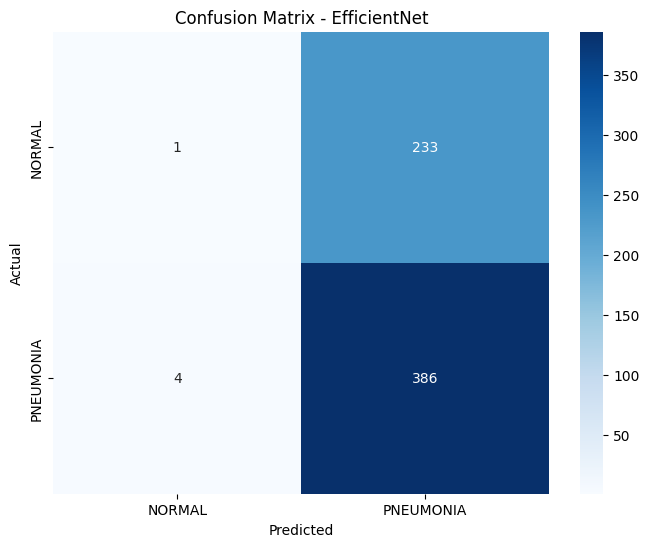

Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step

Classification Report for ResNet:
              precision    recall  f1-score   support

      NORMAL       0.16      0.01      0.02       234
   PNEUMONIA       0.62      0.96      0.75       390

    accuracy                           0.60       624
   macro avg       0.39      0.49      0.39       624
weighted avg       0.45      0.60      0.48       624



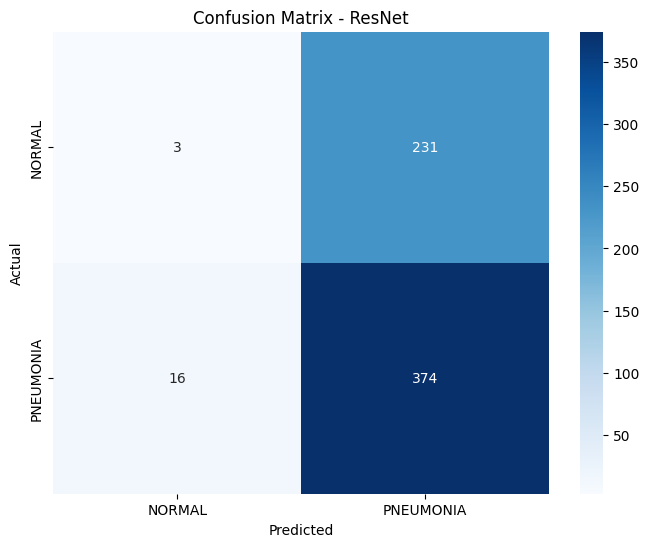

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate_and_plot(model, test_dataset_path, model_name):
    test_datagen = ImageDataGenerator()
    test_dataset = test_datagen.flow_from_directory(
        test_dataset_path,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Predictions and ground truth
    predictions = model.predict(test_dataset)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_dataset.classes
    class_labels = list(test_dataset.class_indices.keys())

    # Classification Report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Ensure correct test dataset path
test_dataset_path = os.path.join(dataset_path, 'chest_xray', 'test')

# Evaluate and plot
evaluate_and_plot(global_trained_models['EfficientNet'][0], test_dataset_path, 'EfficientNet')
evaluate_and_plot(global_trained_models['ResNet'][0], test_dataset_path, 'ResNet')
